In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import mixture
from sklearn.decomposition import PCA
import time
import sys
import scipy.ndimage
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
#%matplotlib notebook
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)
import warnings
warnings.filterwarnings(action='once')

In [2]:
def classify1(features, MX, stop_imm = True, tp = 'full'):
    newdata = features
    n_components = np.arange(1, MX + 1)
    BIC = np.zeros(n_components.shape)
    lowest_bic = np.infty
    best_gmm = None

    for i, n in enumerate(n_components):        
        gmm = GaussianMixture(n_components=n, covariance_type=tp, random_state=0)
        gmm.fit(newdata)
        BIC[i] = gmm.bic(newdata)
        print(n, BIC[i], np.abs(BIC[i] - lowest_bic) / np.abs(BIC[i]))
        if BIC[i] < lowest_bic:
            lowest_bic = BIC[i]
            best_gmm = gmm
        elif stop_imm:
            break

    best_gmm = GaussianMixture(n_components=best_gmm.n_components, covariance_type=tp, random_state=0)
    best_gmm.fit(features)

    print(best_gmm.n_components)
    plt.figure()
    plt.plot(BIC)
    plt.show()
    return best_gmm

def classify2(features, MX, MN=1):
    parameters = {
        'n_components' : np.arange(MN, MX + 1)
    }
    clf = GridSearchCV(GaussianMixture(covariance_type='full', random_state=0), parameters, cv=5, n_jobs=-1)
    clf.fit(features)
    print("n_components", clf.best_estimator_.n_components)
    return clf.best_estimator_

def plot_array(arr):
    ny, nx = arr.shape
    xv, yv = np.meshgrid(np.linspace(0, nx, nx), np.linspace(0, ny, ny))
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(xv,yv,arr)
    plt.show()

In [3]:
df = pd.read_csv("data_ped_train.csv")
df.drop(df.columns[0], inplace=True, axis=1)
scaler = MinMaxScaler()
df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df.columns[2:])


#df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
#from sklearn.decomposition import PCA
#pca = PCA(0.99, whiten=True)
#df2 = pd.DataFrame(pca.fit_transform(df2))

#df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
#df2 = pd.DataFrame(df2, columns=df.columns[2:])


display(df2.describe())
display(df2.head(5))

,x,y,w,h,Rf,mx,my
count,22984.000000,22984.000000,22984.000000,22984.000000,22984.0,22984.000000,22984.000000
mean,0.587877,0.305325,0.191331,0.165067,0.0,0.479639,0.533272
std,0.174215,0.214232,0.125147,0.132206,0.0,0.031056,0.071442
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.480969,0.155340,0.101695,0.078740,0.0,0.472222,0.507692
50%,0.576701,0.234951,0.152542,0.118110,0.0,0.486111,0.523077
75%,0.715110,0.405825,0.237288,0.220472,0.0,0.500000,0.553846
max,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


,x,y,w,h,Rf,mx,my
0,0.475202,0.091262,0.093220,0.039370,0.0,0.500000,0.523077
1,0.529412,0.106796,0.084746,0.055118,0.0,0.486111,0.538462
2,0.579008,0.085437,0.093220,0.062992,0.0,0.500000,0.538462
3,0.635525,0.112621,0.084746,0.078740,0.0,0.500000,0.523077
4,0.700115,0.190291,0.152542,0.110236,0.0,0.486111,0.507692


1 -595878.640016 inf
2 -705136.99915 0.154946285991
3 -725417.860077 0.0279574877372
4 -751817.643968 0.0351146107075
5 -762124.939885 0.0135244175567
6 -769167.644767 0.00915626772581
7 -775592.636289 0.00828397695107
8 -792728.861838 0.0216167549509
9 -798374.430783 0.00707132985075
10 -803104.836026 0.00589014662926
11 -806314.175099 0.00398025877825
12 -807710.316119 0.00172851700909
13 -808364.756346 0.000809585303811
14 -807851.515694 0.000635315576846
13


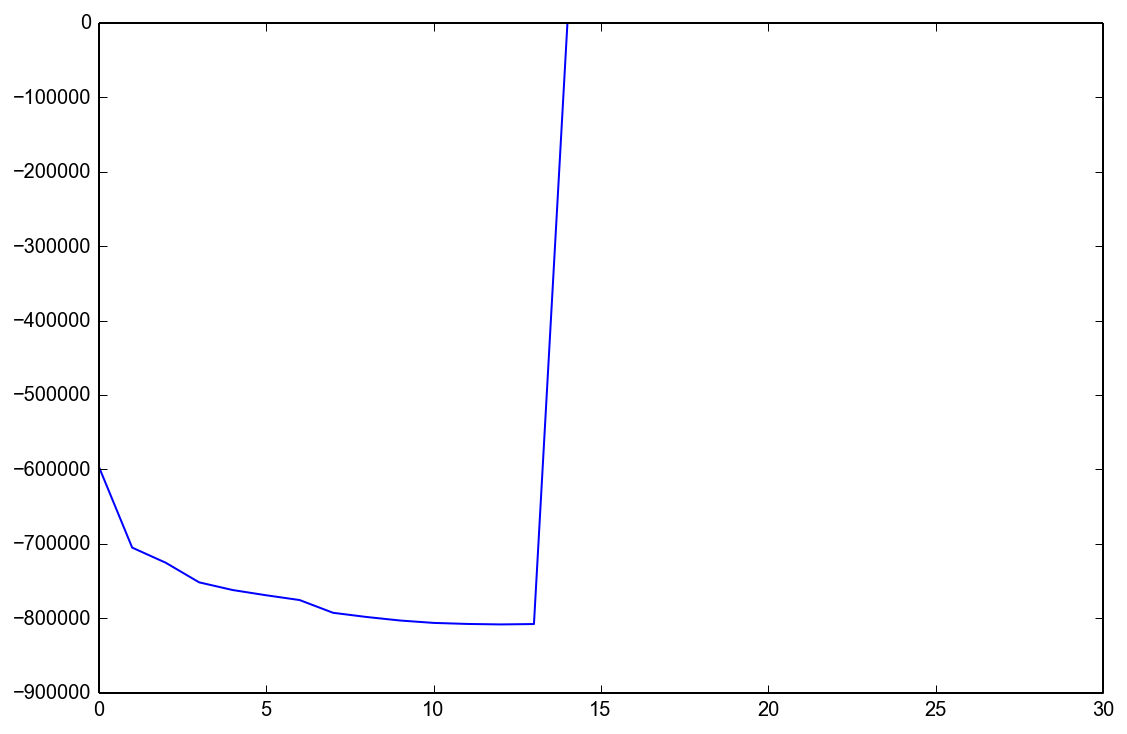

In [4]:
bgmm = classify1(df2, 30, True)

In [5]:
def extend_set(df):
    df_tmp = df[["time", "frame"]].groupby(['time', 'frame']).agg('count')
    df_tmp.reset_index(inplace=True)

    first_time = df_tmp.iloc[0]["time"] 
    first_frame = df_tmp.iloc[0]["frame"]

    last_time = df_tmp.iloc[len(df_tmp) - 1]["time"]
    last_frame = df_tmp.iloc[len(df_tmp) - 1]["frame"]

    dt_time = df_tmp.iloc[len(df_tmp) - 1]["time"] - df_tmp.iloc[len(df_tmp) - 2]["time"]
    dt_frame = df_tmp.iloc[len(df_tmp) - 1]["frame"] - df_tmp.iloc[len(df_tmp) - 2]["frame"]

    df_app = df.apply(lambda x: [x['time'] - first_time + last_time + dt_time, x['frame'] - first_frame + last_frame + dt_frame] + list(x[2:]), axis=1)
    df_app = df.append(df_app)
    df_app.reset_index(inplace=True, drop=True)
    return df_app
df = extend_set(df)
df = extend_set(df)
df = extend_set(df)

df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
df2 = pd.DataFrame(scaler.transform(df2), columns=df.columns[2:])

In [6]:
df3 = pd.DataFrame(bgmm.predict_proba(df2))
df3["time"] = df["time"]
df3["frame"] = df["frame"]
df3 = df3.groupby(['time', 'frame']).agg('max')
df3.reset_index(inplace=True)

#display(df3.head(11))

#df3 = df3.apply(lambda x: [x['time'], x['frame']] + list(x[2:] / x[2:].sum()), axis=1)
#df3_test = df3_test.apply(lambda x: [x['time'], x['frame']] + list(x[2:] / x[2:].sum()), axis=1)

display(df3.head(11))

#arr = df3_test.drop(["frame", "time"], axis=1)
#display(np.array(arr))
#display(np.array(arr) / np.linalg.norm(arr, axis=1))

PN = []

last_t = df3.iloc[0]["time"]

pn = []

#seg_len = 15
seg_len = 30
seg_n_len = 15

i = 0
i_next = 0
i_next_tm = 0
while i < len(df3) - 1:
    r = df3.iloc[i]
    pn.append(r.drop(["time", "frame"]).ravel())
    if (i_next == 0) and (r.time - last_t > seg_n_len):
        i_next = i + 1
        i_next_tm = df3.iloc[i + 1].time
    if r.time - last_t > seg_len:
        last_t = i_next_tm
        i = i_next
        i_next = 0        
        if len(pn) >= bgmm.n_components:        
            PN.append(pn)
        else:
            print("too short", len(pn))
        pn = []
    else:
        i += 1

#display(PN[0])        
        
print("N =",len(PN))
for i in range(len(PN)):
    print("N[",i,"]=",len(PN[i]))

,time,frame,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.64,16.0,0.993732,9.792622e-01,0.843017,0.997275,2.322812e-01,2.073777e-02,0.995062,0.012037,4.988137e-15,0.001604,0.010929,1.000000,0.000004
1,0.76,19.0,0.993720,9.977734e-01,0.972315,0.992621,1.863908e-01,2.226634e-03,0.993036,0.005874,3.668634e-14,0.001604,0.010929,1.000000,0.000004
2,0.88,22.0,0.987913,9.977734e-01,0.973695,0.981344,3.074223e-02,2.226634e-03,0.995028,0.019543,6.243285e-13,0.001604,0.010929,1.000000,0.000004
3,1.00,25.0,0.989735,9.977734e-01,0.999473,0.948919,8.326741e-03,2.226634e-03,0.991954,0.044605,4.271114e-13,0.003357,0.010929,1.000000,0.000198
4,1.12,28.0,0.993614,3.429581e-22,0.999999,0.993742,1.082280e-03,1.468777e-13,0.992758,0.028353,1.173563e-08,0.001007,0.005700,0.000938,0.000002
5,1.24,31.0,0.993199,4.396668e-22,1.000000,0.985440,2.640698e-04,4.137235e-14,0.996422,0.104087,1.049099e-08,0.005628,0.005700,0.001128,0.000395
6,1.36,34.0,0.989065,1.232614e-22,1.000000,0.962681,8.428234e-05,1.675173e-14,0.993735,0.009646,6.246524e-08,0.001253,0.005700,0.000938,0.000002
7,1.48,37.0,0.990027,1.158595e-22,0.999988,0.915015,3.014017e-05,8.025184e-15,0.997359,0.046771,7.879046e-09,0.001591,0.005700,0.000938,0.000003
8,1.60,40.0,0.980749,1.107489e-22,0.999953,0.993950,1.404873e-06,8.144910e-16,0.992100,0.022257,1.205339e-11,0.001737,0.002909,0.000442,0.000003
9,1.72,43.0,0.985884,1.511855e-22,0.999892,0.987847,3.324454e-07,2.414558e-16,0.996482,0.068193,1.658084e-11,0.011246,0.002909,0.000442,0.000038


N = 119
N[ 0 ]= 252
N[ 1 ]= 252
N[ 2 ]= 252
N[ 3 ]= 252
N[ 4 ]= 252
N[ 5 ]= 252
N[ 6 ]= 252
N[ 7 ]= 252
N[ 8 ]= 252
N[ 9 ]= 252
N[ 10 ]= 252
N[ 11 ]= 252
N[ 12 ]= 252
N[ 13 ]= 252
N[ 14 ]= 252
N[ 15 ]= 252
N[ 16 ]= 251
N[ 17 ]= 252
N[ 18 ]= 252
N[ 19 ]= 252
N[ 20 ]= 252
N[ 21 ]= 252
N[ 22 ]= 252
N[ 23 ]= 252
N[ 24 ]= 252
N[ 25 ]= 252
N[ 26 ]= 252
N[ 27 ]= 252
N[ 28 ]= 252
N[ 29 ]= 252
N[ 30 ]= 252
N[ 31 ]= 252
N[ 32 ]= 252
N[ 33 ]= 251
N[ 34 ]= 252
N[ 35 ]= 252
N[ 36 ]= 252
N[ 37 ]= 251
N[ 38 ]= 251
N[ 39 ]= 252
N[ 40 ]= 252
N[ 41 ]= 252
N[ 42 ]= 252
N[ 43 ]= 252
N[ 44 ]= 252
N[ 45 ]= 252
N[ 46 ]= 252
N[ 47 ]= 252
N[ 48 ]= 252
N[ 49 ]= 252
N[ 50 ]= 252
N[ 51 ]= 252
N[ 52 ]= 252
N[ 53 ]= 251
N[ 54 ]= 252
N[ 55 ]= 252
N[ 56 ]= 252
N[ 57 ]= 252
N[ 58 ]= 252
N[ 59 ]= 252
N[ 60 ]= 252
N[ 61 ]= 252
N[ 62 ]= 252
N[ 63 ]= 252
N[ 64 ]= 252
N[ 65 ]= 252
N[ 66 ]= 252
N[ 67 ]= 251
N[ 68 ]= 252
N[ 69 ]= 252
N[ 70 ]= 252
N[ 71 ]= 252
N[ 72 ]= 252
N[ 73 ]= 252
N[ 74 ]= 252
N[ 75 ]= 252
N[ 76 ]= 252
N

In [7]:
from hmmlearn import hmm

def my_hmm_score(h, samples):
    s = h.score(samples)
    return 0 if s > 0 else s

hmms1 = []

N = len(PN)

for i in range(N):    
    hmm1 = hmm.GaussianHMM(n_components=bgmm.n_components, covariance_type="diag", random_state=0)
    #, n_iter=100, tol=1e-3
    hmm1.fit(PN[i])    
    assert(hmm1.monitor_.converged)
    hmms1.append(hmm1)

/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/hmmlearn-0.2.1-py3.4-linux-x86_64.egg/hmmlearn/base.py:465: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice
/usr/local/lib/python3.4/dist-packages/hmmlearn-0.2.1-py3.4-linux-x86_64.egg/hmmlearn/utils.py:46: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  a_lse = logsumexp(a, axis)


In [8]:
import threading

Sij = np.zeros((N,N), np.float64)

hmm_scores = {}

def hmm_thread(idx):
    for i in idx:
        for j in range(N):                
            if (i, j) in hmm_scores:
                scr1 = hmm_scores[(i, j)]
            else:
                scr1 = hmm_scores[(i, j)] = hmms1[i].score(PN[j])

            if (j, i) in hmm_scores:
                scr2 = hmm_scores[(j, i)]
            else:
                scr2 = hmm_scores[(j, i)] = hmms1[j].score(PN[i])
                            
            s1 = scr1 * (1.0 / len(PN[j]))
            s2 = scr2 * (1.0 / len(PN[i]))
            Sij[i, j] = 0.5 * (s1 + s2)

num_threads = 7

idx_split = np.array_split(range(N), num_threads)

thrs = []
for i in range(num_threads):
    thr = threading.Thread(target=hmm_thread, args=(idx_split[i],))    
    thr.start()
    thrs.append(thr)

for thr in thrs:
    thr.join()

/usr/local/lib/python3.4/dist-packages/hmmlearn-0.2.1-py3.4-linux-x86_64.egg/hmmlearn/base.py:465: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice


In [9]:
from scipy.linalg import fractional_matrix_power

Lij = np.zeros((N,N), np.float64)

for i in range(N):
    s1 = 0    
    for j in range(N):        
        s1 += Sij[i, j]
    Lij[i, i] = s1
Lij2 = fractional_matrix_power(Lij, -0.5)
Snorm = np.dot(np.dot(Lij2, Sij), Lij2).astype('float64')
#plot_array(Snorm)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


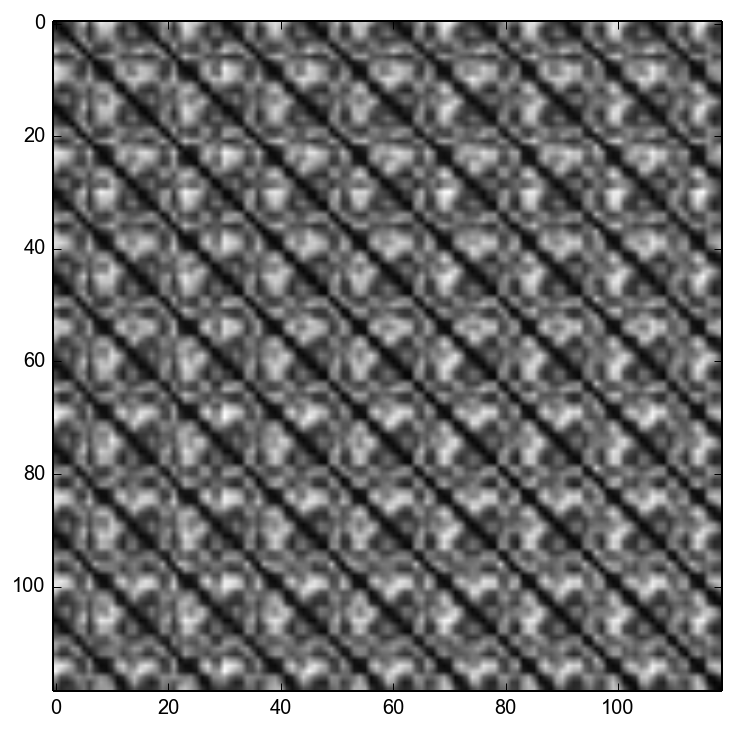

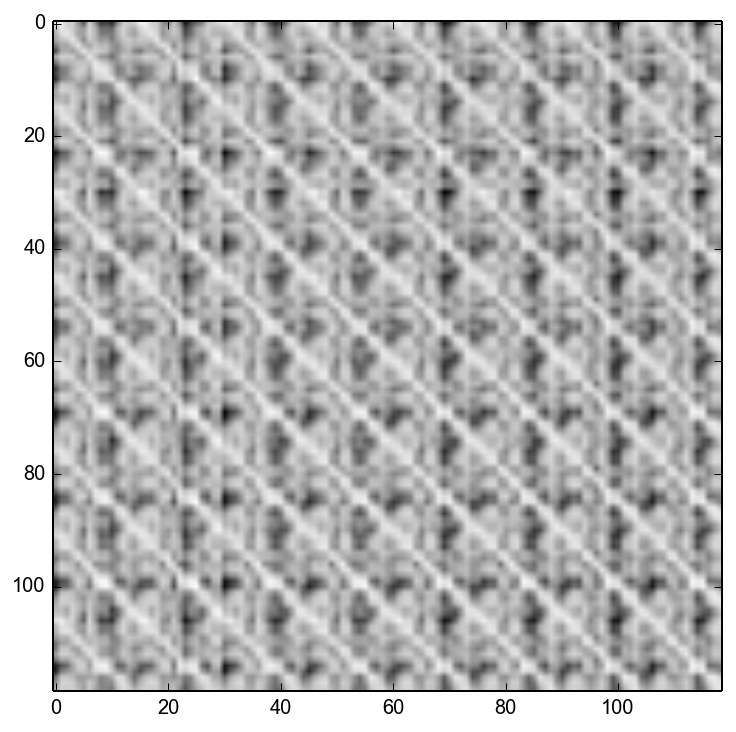

In [10]:
plt.figure()
plt.imshow(Snorm, cmap='gray')
plt.show()

Snorm2 = np.zeros((N,N), np.float64)

Lij3 = np.zeros((N,N), np.float64)


#Sij2 = Sij
#Sij2[Sij2 > 0] = 0
#Sij2 =  -1.0 / Sij2


Sij2 = Sij - np.min(Sij)

#delta = 100000.0
#Sij2 = np.exp(- np.abs(Sij) ** 2 / (2. * delta ** 2))

for i in range(N):
    s1 = 0
    for j in range(N):
        s1 += Sij2[i, j]
    Lij3[i, i] = s1

for i in range(N):    
    for j in range(N):                        
        Snorm2[i, j] = Sij2[i, j] / np.sqrt(Lij3[i, i]) * np.sqrt(Lij3[j, j])
        
#Snorm2 = Snorm2.astype('float64')

#Snorm2 = Sij

#Snorm2 = np.dot(np.dot(Lij2, Sij), Lij2).astype('float64')

plt.figure()
plt.imshow(Snorm2, cmap='gray')
plt.show()

Snorm = Snorm2

Km= 39
(119, 39)
0.447078996598
0.509631929918
0.999982562283
0.749947379366
0.590682243407
0.351068926676
0.999890525137
0.446861996916
0.348261495536
0.984542446916
0.999671865068
0.534890140098
0.994780771721
0.995561036424
0.999960781059
0.682983391575
0.999648397579
0.479006662944
0.998768953822
0.999843174807
0.33242066957
0.995799951702
0.486464865425
0.340864693848
0.952825075519
0.999582464841
0.99962984564
0.387785193197
0.981394460949
0.512089123607
0.243638188958
0.999967261552
0.9977109603
0.998682679946
0.999490432942
0.999940663975
0.99895957208
0.999977448323
0.998224493601
New Km= 29
(119, 29)
1 4499.12815787 inf
2 5880.97024626 0.234968386257
3 5622.01664023 0.199730551191
4 5047.31211198 0.108609085777
5 4501.43713338 0.000512941854784
6 3349.34277196 0.343286866764
7 1628.591524 1.05658860593
8 1080.39892472 0.507398319951
9 450.740506191 1.3969421649
10 543.449555263 0.170593660762
11 1059.58150832 0.574605160006
12 2530.20935736 0.821856438527
13 3456.38361994 0.8

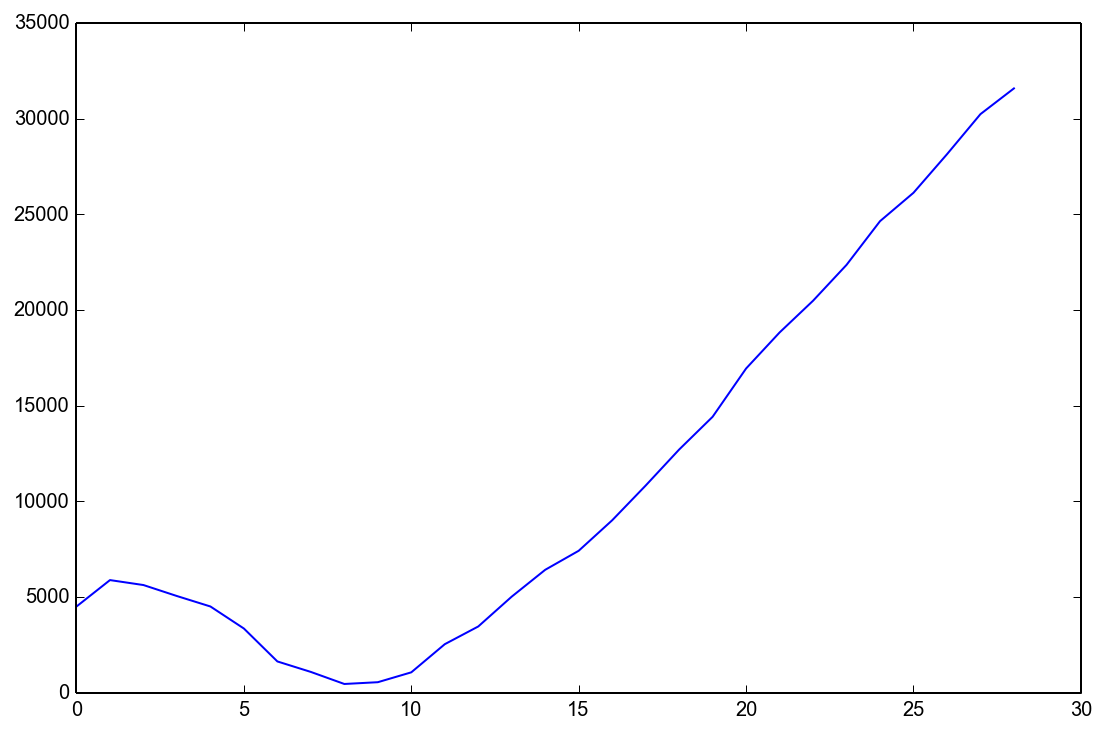

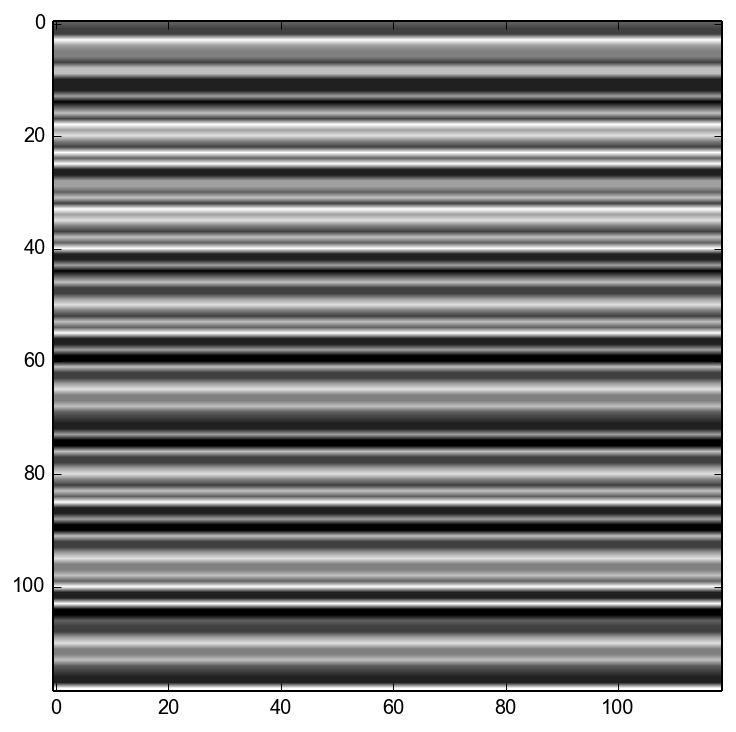

In [20]:
import mixem

Km = int(N / 5)

Snorm_vals, Snorm_vecs = np.linalg.eigh(Sij)

Snorm_vecs = Snorm_vecs.T

for i in range(len(Snorm_vecs)):
    Snorm_vecs[i, :] *= Snorm_vals[i]

indices = np.argsort(Snorm_vals)[::-1][:Km]

#print(indices)

#print(Snorm_vals[indices])

#top_vals = Snorm_vals[indices]
top_vecs = Snorm_vecs[indices].T


#eig_val, eig_vect = scipy.sparse.linalg.eigs(Snorm, Km)
#X = eig_vect.real
#rows_norm = np.linalg.norm(X, axis=1, ord=2)
#Y = (X.T / rows_norm).T

#s, Vh = np.linalg.eig(Snorm)
#eigenvector = Vh.real[:,:Km].copy()
#eigenvector /= ((eigenvector**2).sum(axis=1)[:,np.newaxis]**.5)

#top_vecs = eigenvector

assert(N == len(top_vecs))

print("Km=",Km)
print(top_vecs.shape)

#top_vals_normed = top_vals - np.min(top_vals)
#top_vals_normed = top_vals_normed / np.max(top_vals_normed)

def my_em(data, distributions, initial_weights=None, max_iterations=100, tol=1e-15, tol_iters=10, progress_callback=mixem.simple_progress):    
    n_distr = len(distributions)
    n_data = data.shape[0]

    if initial_weights is not None:
        weight = np.array(initial_weights)
    else:
        weight = np.ones((n_distr,))

    last_ll = np.zeros((tol_iters, ))
    resp = np.empty((n_data, n_distr))
    log_density = np.empty((n_data, n_distr))
    
    Rk = 0

    iteration = 0
    while True:
        # E-step #######

        # compute responsibilities
        for d in range(n_distr):
            log_density[:, d] = distributions[d].log_density(data)

        # normalize responsibilities of distributions so they sum up to one for example
        resp = weight[np.newaxis, :] * np.exp(log_density)
        resp /= np.sum(resp, axis=1)[:, np.newaxis]

        log_likelihood = np.sum(resp * log_density)

        # M-step #######
        h1 = resp[:, 0]
        h2 = resp[:, 1]
        h3 = resp[:, 2]
        
        Rk = 1.0 - np.mean(h1)
        wk = np.mean(h2) / Rk
                                
        for d in range(n_distr):            
            if d != 0:
                distributions[d].estimate_parameters(data, resp[:, d])
                distributions[d].sigma += 1e-6
        
        weight[0] = 1.0 - Rk
        weight[1] = wk*Rk
        weight[2] = (1.0 - wk)*Rk
        
        assert(np.allclose(np.sum(weight), 1.0))

        if progress_callback:
            progress_callback(iteration, weight, distributions, log_likelihood)

        # Convergence check #######
        if np.isnan(log_likelihood):
            last_ll[0] = log_likelihood
            break

        if iteration >= tol_iters and np.abs(log_likelihood - last_ll[-1]) / np.abs(log_likelihood) <= tol:
            last_ll[0] = log_likelihood
            break

        if iteration >= max_iterations:
            last_ll[0] = log_likelihood
            break

        # store value of current iteration in last_ll[0]
        # and shift older values to the right
        last_ll[1:] = last_ll[:-1]
        last_ll[0] = log_likelihood

        iteration += 1

    return Rk, distributions, last_ll[0]

new_top_vecs = []
new_rks = []

for i in range(Km):
    mk1 = np.sum(top_vecs[:, i]) * (1.0 / N)
    sigma_k1 = np.sqrt(np.sum((top_vecs[:, i] - mk1) ** 2) * (1.0 / N))    
                            
    gm1 = GaussianMixture(n_components=1, random_state=0, covariance_type='diag', means_init=[[mk1]], precisions_init=[[1.0 / (sigma_k1 * sigma_k1)]])
    gm1.fit(top_vecs[:, i].reshape(-1, 1))
            
    dist0 = mixem.distribution.NormalDistribution(gm1.means_[0][0], np.sqrt(gm1.covariances_[0][0]))
                
    gm1 = GaussianMixture(n_components=2, random_state=0, covariance_type='diag')
    gm1.fit(top_vecs[:, i].reshape(-1, 1))
                    
    max_ds = [
        dist0,
        mixem.distribution.NormalDistribution(gm1.means_[0][0], np.sqrt(gm1.covariances_[0][0])),
        mixem.distribution.NormalDistribution(gm1.means_[1][0], np.sqrt(gm1.covariances_[1][0]))]
            
    max_ws = [0.5, gm1.weights_[0] * 0.5, gm1.weights_[1] * 0.5]
        
    Rk, ds, ll = my_em(top_vecs[:, i], max_ds,
        initial_weights = max_ws, progress_callback=None,
        tol_iters=100, max_iterations=10000, tol=1e-6)
        
    print(Rk)
    if (Rk >= 0.5):
        new_top_vecs.append(top_vecs[:, i])
        new_rks.append(Rk)
                
top_vecs = np.array(new_top_vecs)
new_rks = np.array(new_rks)

new_rks /= np.sum(new_rks)

for i in range(len(top_vecs)):
    top_vecs[i, :] *= new_rks[i]

Km = len(top_vecs)
print("New Km=",Km)
top_vecs = top_vecs.T
print(top_vecs.shape)

eig_gmm = classify1(top_vecs, Km, False)

finalK = eig_gmm.n_components

top_classes = eig_gmm.predict(top_vecs)

AM = np.zeros((N,N), np.float64)
for i in range(N):            
    for j in range(N):            
        AM[i, j] = top_classes[i]
            
plt.figure()
plt.imshow(AM, cmap='gray')
plt.show()

10


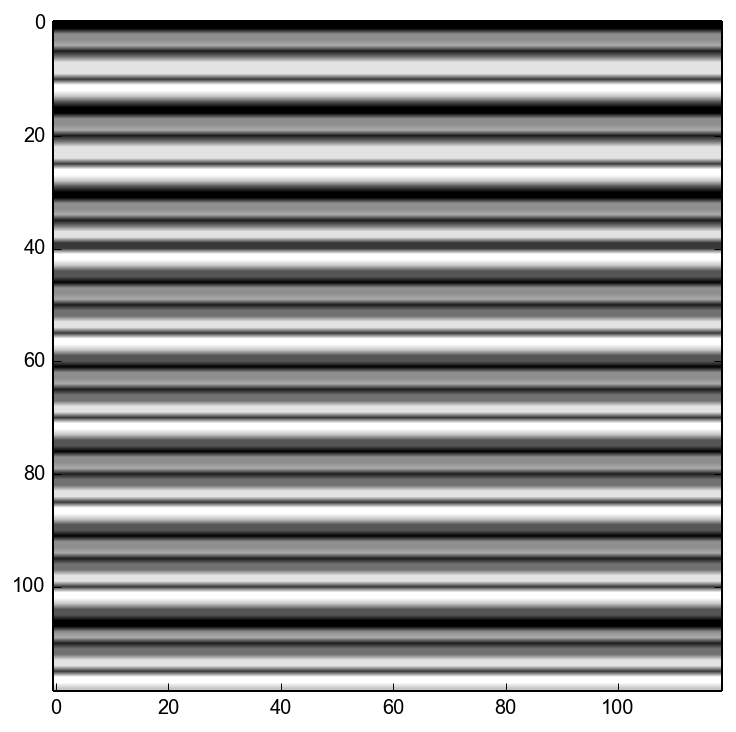

In [12]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(affinity='precomputed').fit(Snorm)

finalK2 = len(af.cluster_centers_indices_)
print(finalK2)

AM = np.zeros((N,N), np.float64)
for i in range(N):            
    for j in range(N):            
        AM[i, j] = af.labels_[i]
            
plt.figure()
plt.imshow(AM, cmap='gray')
plt.show()

In [13]:
#finalK = 7
#eig_gmm = GaussianMixture(n_components=finalK, covariance_type='full', random_state=0)
#eig_gmm.fit(top_vecs)

final_hmms = []
final_nk = []
top_classes = eig_gmm.predict(top_vecs)
#top_classes = af.labels_
#finalK = finalK2
for i in range(finalK):    
    tmp1 = []
    num = 0
    tmp1_ls = []
    for j in range(N):
        if top_classes[j] == i:
            tmp1 += PN[j]
            tmp1_ls.append(len(PN[j]))
            num += 1
    hmm1 = hmm.GaussianHMM(n_components=bgmm.n_components, covariance_type="diag", random_state=0)
    hmm1.fit(tmp1, tmp1_ls)
    #hmm1.fit(tmp1)
    final_hmms.append(hmm1)
    final_nk.append(num)    

/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/hmmlearn-0.2.1-py3.4-linux-x86_64.egg/hmmlearn/base.py:465: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice
/usr/local/lib/python3.4/dist-packages/hmmlearn-0.2.1-py3.4-linux-x86_64.egg/hmmlearn/utils.py:46: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  a_lse = logsumexp(a, axis)


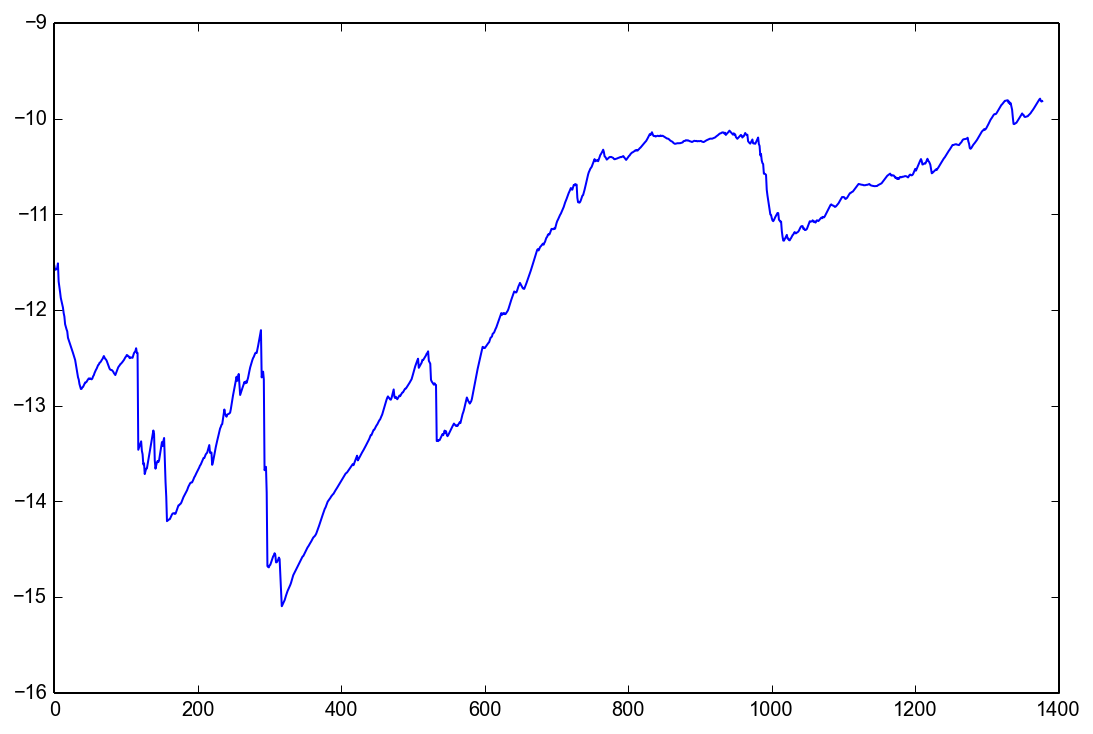

In [17]:
from hmmlearn.stats import _log_multivariate_normal_density_diag
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted
from hmmlearn.utils import log_mask_zero
from scipy.special import logsumexp

df_test = pd.read_csv("data_ped_test.csv")
df_test.drop(df_test.columns[0], inplace=True, axis=1)
#df_test = extend_set(df_test)
#df_test = extend_set(df_test)
#df_test = extend_set(df_test)

df2_test = df_test.drop([df_test.columns[0], df_test.columns[1]], axis=1)
df2_test = pd.DataFrame(scaler.transform(df2_test), columns=df_test.columns[2:])

df3_test = pd.DataFrame(bgmm.predict_proba(df2_test))
df3_test["time"] = df_test["time"]
df3_test["frame"] = df_test["frame"]
df3_test = df3_test.groupby(['time', 'frame']).agg('max')
df3_test.reset_index(inplace=True)

lattices = []

work_buffer = np.zeros(bgmm.n_components)

def my_forward_pass(hmm, fwdlattice, framelogprob, n_samples):
    n_samples_aa, n_components = framelogprob.shape    
    log_startprob = log_mask_zero(hmm.startprob_)
    log_transmat = log_mask_zero(hmm.transmat_)    
    if (n_samples == 1):
        for i in range(n_components):            
            fwdlattice[0, i] = log_startprob[i] + framelogprob[0, i]
    else:                    
        for j in range(n_components):
            for i in range(n_components):
                work_buffer[i] = fwdlattice[n_samples - 2, i] + log_transmat[i, j]            
            fwdlattice[n_samples - 1, j] = logsumexp(work_buffer) + framelogprob[0, j]
    return logsumexp(fwdlattice[n_samples - 1])

def calc_final_prob(samples):
    i_a = []
    i_b = []
    
    for i in range(finalK):                                
        lgg = _log_multivariate_normal_density_diag(check_array([samples[-1]]), final_hmms[i].means_, final_hmms[i]._covars_)        
        my_s = my_forward_pass(final_hmms[i], lattices[i], lgg, len(samples))
        act_s = my_s
        
        #act_s = final_hmms[i].score(samples)        
        #assert(np.allclose(my_s, act_s))
                        
        i_a.append(act_s)
        i_b.append(float(final_nk[i]) / float(N))        
        
    return scipy.special.logsumexp(a=i_a, b=i_b)

def calc_final_prob_i(samples, i):
    lgg = _log_multivariate_normal_density_diag(check_array([samples[-1]]), final_hmms[i].means_, final_hmms[i]._covars_)
    return my_forward_pass(final_hmms[i], lattices[i], lgg, len(samples))

TestPN = df3_test.drop(["time", "frame"], axis=1)
#TestPN = TestPN.head(1500)

for i in range(finalK):
    check_is_fitted(final_hmms[i], "startprob_")
    final_hmms[i]._check()
    lattices.append(np.zeros((len(TestPN), bgmm.n_components)))
                    
test_arr = []
scrs = []
scrs_raw = []
j = 1

for i in range(len(TestPN)):
    r = TestPN.iloc[i].ravel()
    test_arr.append(r)
    prb = calc_final_prob(test_arr)
    scrs.append(prb / j)
    scrs_raw.append(prb)    
    j += 1        
    
plt.figure()
plt.plot(scrs[int(seg_len * 1.5 * 10):])
plt.show()

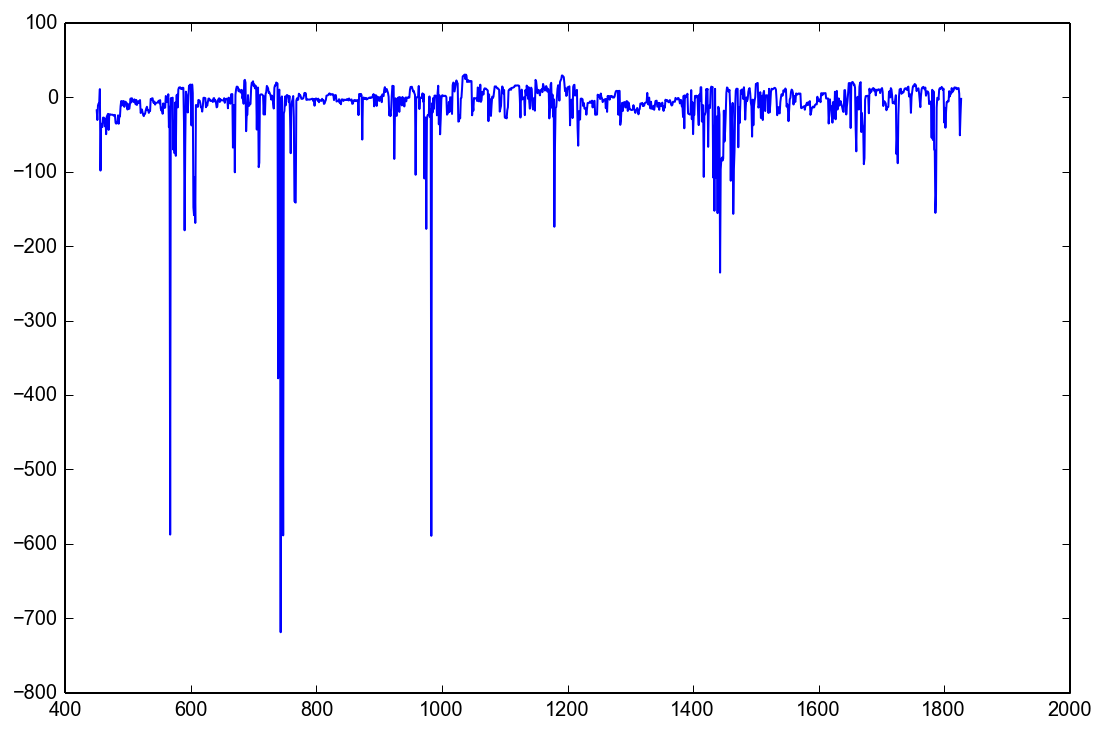

In [18]:
scrs2 = []

prev = 0

for i in range(len(TestPN)):    
    scrs2.append((scrs_raw[i] - prev) / (0 + 1))
    prev = scrs_raw[i]
    
plt.figure()
plt.plot(range(int(seg_len * 1.5 * 10), len(scrs2)), scrs2[int(seg_len * 1.5 * 10):])
plt.show()    

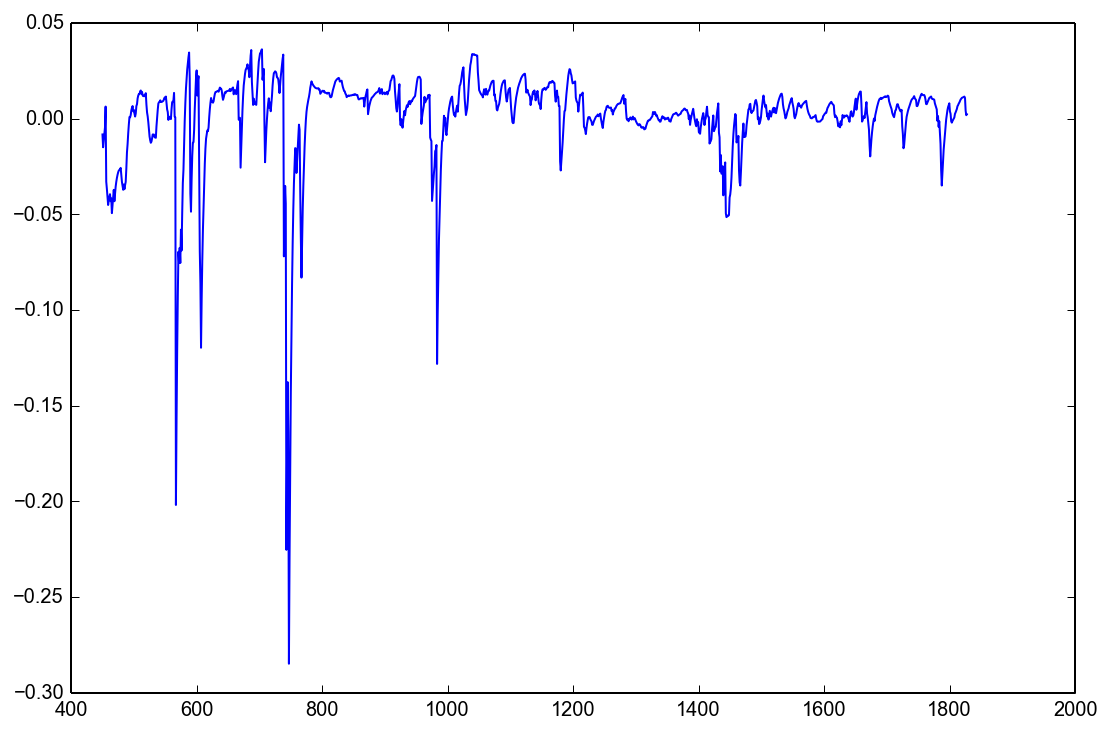

In [19]:
import traceback

Qt = 0
alpha = 0.2

first_frm = int(seg_len * 1.5 * 10)
first_frm_num = 0

qts = {}
qts_lst = []
frm_to_i = {}
for i in range(len(scrs)):
    if i == 0:
        Qt = scrs[0]
    else:
        Qt = (1 - alpha) * Qt + alpha * (scrs[i] - scrs[i - 1])
    #Qt = scrs2[i]
    qts[df3_test.iloc[i]["frame"]] = Qt
    frm_to_i[df3_test.iloc[i]["frame"]] = i
    qts_lst.append(Qt)
    if i == first_frm:
        first_frm_num = df3_test.iloc[i]["frame"]
            
plt.figure()
plt.plot(range(first_frm, len(qts_lst)), qts_lst[first_frm:])
plt.show()

#cap = cv2.VideoCapture('Datasets/Pedestrian/train.avi')
#cap = cv2.VideoCapture('z3.avi')
cap = cv2.VideoCapture('reception_short_train.avi')
#cap = cv2.VideoCapture('Datasets/Crossroads1/test.avi')
ok, frame = cap.read()
aspect = float(frame.shape[1]) / frame.shape[0]
cap.release()
#cap = cv2.VideoCapture('Datasets/Pedestrian/train.avi')
#cap = cv2.VideoCapture('z3.avi')
cap = cv2.VideoCapture('reception_short_train.avi')
#cap = cv2.VideoCapture('Datasets/Crossroads1/test.avi')

try:
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        frame = cv2.resize(frame, (int(240 * aspect), 240), interpolation = cv2.INTER_AREA)    
        fnum = cap.get(cv2.CAP_PROP_POS_FRAMES)    
        delay = 1
        if (fnum >= first_frm_num) and (fnum in qts):
            if qts[fnum] < -0.1:
                cv2.rectangle(frame, (0,0), (frame.shape[1], frame.shape[0]), (0,0,255), 10)
                delay = 0
                #print("frame", frm_to_i[fnum])
        cv2.imshow('frame', frame)        
        k = cv2.waitKey(delay) & 0xff        
        #if delay == 0:
        #    time.sleep(1)
        if k == 32:
            k = cv2.waitKey() & 0xff
        if k == 27:
            break
except Exception as e:    
    traceback.print_exc()

cap.release()
cv2.destroyAllWindows()